Running Alpha=0.2, Width=5, Depth=1...
Running Alpha=0.2, Width=5, Depth=2...
Running Alpha=0.2, Width=5, Depth=3...
Running Alpha=0.2, Width=10, Depth=1...
Running Alpha=0.2, Width=10, Depth=2...
Running Alpha=0.2, Width=10, Depth=3...
Running Alpha=0.2, Width=15, Depth=1...
Running Alpha=0.2, Width=15, Depth=2...
Running Alpha=0.2, Width=15, Depth=3...
Running Alpha=0.4, Width=5, Depth=1...
Running Alpha=0.4, Width=5, Depth=2...
Running Alpha=0.4, Width=5, Depth=3...
Running Alpha=0.4, Width=10, Depth=1...
Running Alpha=0.4, Width=10, Depth=2...
Running Alpha=0.4, Width=10, Depth=3...
Running Alpha=0.4, Width=15, Depth=1...
Running Alpha=0.4, Width=15, Depth=2...
Running Alpha=0.4, Width=15, Depth=3...
Running Alpha=0.6, Width=5, Depth=1...
Running Alpha=0.6, Width=5, Depth=2...
Running Alpha=0.6, Width=5, Depth=3...
Running Alpha=0.6, Width=10, Depth=1...
Running Alpha=0.6, Width=10, Depth=2...
Running Alpha=0.6, Width=10, Depth=3...
Running Alpha=0.6, Width=15, Depth=1...
Running A

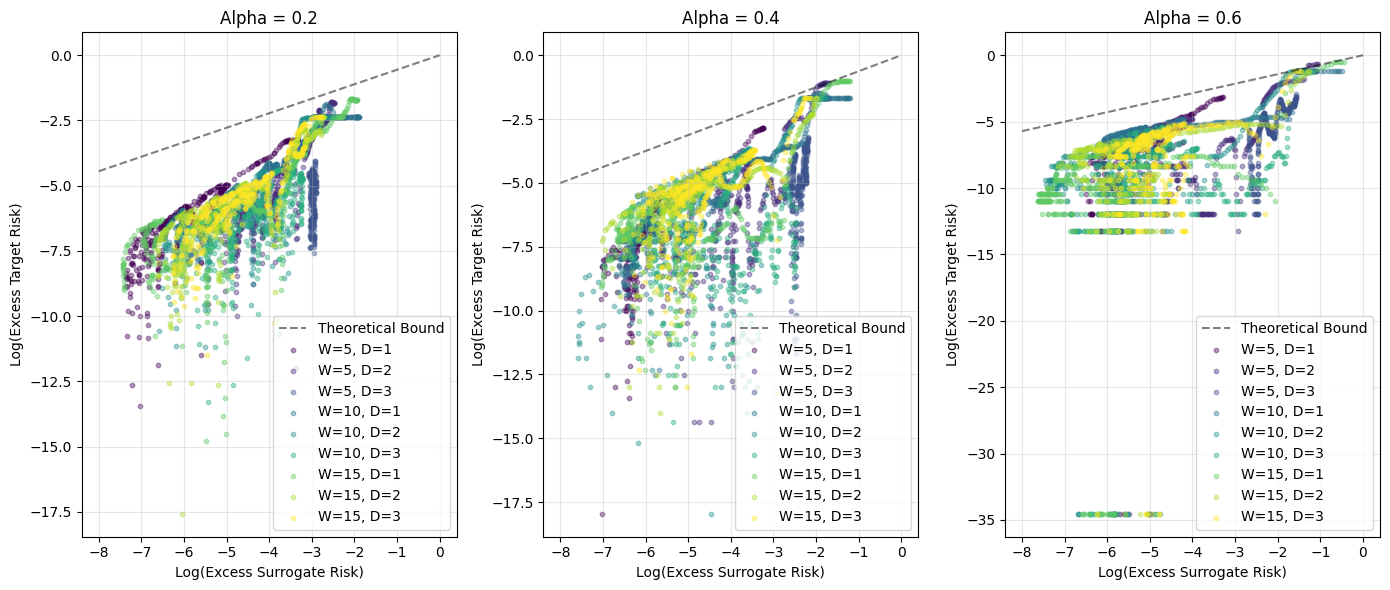

In [3]:
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# --- 1. Tsybakov Noise and Risk Definitions (Vectorized) ---

# Activation / Link functions
eta = lambda x: 1/(1+np.exp(-x))
inverse_eta = lambda x: np.log(x/(1-x))

# Risks
loss = lambda x: np.log(1 + np.exp(-x))
margin_loss = lambda h_x, y: loss(y * h_x)

# Vectorized Risk Calculations
# h_val is a vector of predictions, x is a vector of features
C_surr_val = lambda h_val, x: eta(x) * margin_loss(h_val, 1) + (1-eta(x)) * margin_loss(h_val, -1)
C_surr_star = lambda x: -1*(eta(x) * np.log(eta(x)) + (1-eta(x))*np.log(1-eta(x))) 
C_target_val = lambda h_val, x: eta(x) * (h_val < 0) + (1-eta(x)) * (h_val > 0) 
C_target_star = lambda x: np.minimum(eta(x), 1-eta(x))

# --- 2. Dynamic Forward Pass Function ---
def get_logits_dynamic(classifier, X_input):
    """
    Manually computes the forward pass for an MLPClassifier of ANY depth.
    Returns the raw logits (before sigmoid/softmax).
    """
    if not hasattr(classifier, 'coefs_'):
        return np.zeros(X_input.shape[0])

    activations = X_input

    # Iterate through hidden layers (all except the last set of weights)
    # classifier.coefs_ is a list of weight matrices [Input->H1, H1->H2, ..., Hlast->Output]
    for i in range(len(classifier.coefs_) - 1):
        W = classifier.coefs_[i]
        b = classifier.intercepts_[i]
        
        # Linear Step
        z = np.dot(activations, W) + b
        
        # ReLU Activation
        activations = np.maximum(0, z)

    # Output Layer (Linear only, no activation)
    W_last = classifier.coefs_[-1]
    b_last = classifier.intercepts_[-1]
    logits = np.dot(activations, W_last) + b_last
    
    return logits.ravel()

# --- 3. Experiment Function ---

def run_test(X, Y, width, depth, chunk_size=5):
    # Construct hidden_layer_sizes tuple based on depth
    # e.g., depth=2, width=10 -> (10, 10)
    layers = tuple([width] * depth)
    
    classifier = MLPClassifier(
        hidden_layer_sizes=layers,
        activation='relu',
        solver='sgd',               # Fixed as requested
        learning_rate='constant',
        learning_rate_init=0.005,   # Fixed as requested
        alpha=0,                    # No L2 regularization
        random_state=42,
        max_iter=1                  # 1 epoch per partial_fit
    )
    
    all_classes = np.unique(Y)
    
    # Tracking mean errors
    mean_surr_history = []
    mean_target_history = []

    num_chunks = len(X) // chunk_size
    
    # Training Loop
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        X_chunk = X[start_idx:end_idx]
        y_chunk = Y[start_idx:end_idx]

        # Partial Fit
        if i == 0:
            classifier.partial_fit(X_chunk, y_chunk, classes=all_classes)
        else:
            classifier.partial_fit(X_chunk, y_chunk)
        
        # --- Evaluate on FULL Dataset (Vectorized) ---
        # 1. Get predictions for all X
        h_vals = get_logits_dynamic(classifier, X)
        x_flat = X.ravel()
        
        # 2. Compute Risks
        surr_loss = C_surr_val(h_vals, x_flat)
        surr_star = C_surr_star(x_flat)
        target_loss = C_target_val(h_vals, x_flat)
        target_star = C_target_star(x_flat)

        # 3. Compute Excess Risk (Delta)
        # We take the mean immediately to save memory/plotting time
        mean_delta_surr = np.mean(surr_loss - surr_star)
        mean_delta_target = np.mean(target_loss - target_star)
        
        mean_surr_history.append(mean_delta_surr)
        mean_target_history.append(mean_delta_target)

    return mean_surr_history, mean_target_history

# --- 4. Main Execution & Plotting ---

# Parameters to test
alphas_to_test = [0.2, 0.4, 0.6]
widths_to_test = [5, 10, 15]
depths_to_test = [1, 2, 3]

# Fixed Data Generation Params
n_samples = 1000

fig, axes = plt.subplots(1, len(alphas_to_test), figsize=(14, 6), sharey=False)
if len(alphas_to_test) == 1: axes = [axes]

for ax_idx, alpha in enumerate(alphas_to_test):
    # --- Generate Data for this Alpha ---
    beta = alpha / (1 - alpha)
    
    # Tsybakov noise distribution
    signal = [((x) ** (1/beta))/2 for x in np.random.rand(n_samples)] + [0.01, 0.49]
    arr = []
    for t in signal:
        arr.extend([0.5 + t, 0.5 - t])
    
    # We generated 2x points in the loop, trim to n_samples
    # arr = arr[n_samples:]
    
    X_raw = [inverse_eta(x) for x in arr]
    Y_raw = [np.random.binomial(n=1, p=eta(x))*2 - 1 for x in X_raw]

    # Shuffle
    indices = np.random.permutation(len(X_raw))
    X = np.array(X_raw)[indices].reshape(-1, 1)
    Y = np.array(Y_raw)[indices]

    ax = axes[ax_idx]
    ax.set_title(f"Alpha = {alpha}")
    ax.set_xlabel("Log(Excess Surrogate Risk)")
    ax.set_ylabel("Log(Excess Target Risk)")
    
    # Theoretical Bound Line (y = 1/(2-alpha) * x)
    # We plot a reference line
    x_ref = np.linspace(-8, 0, 100)
    y_ref = (1/(2-alpha)) * x_ref
    # y_ref = x_ref
    ax.plot(x_ref, y_ref, 'k--', label="Theoretical Bound", alpha=0.5)

    # --- Run Tests ---
    colors = plt.cm.viridis(np.linspace(0, 1, len(widths_to_test)*len(depths_to_test)))
    color_idx = 0
    
    for width in widths_to_test:
        for depth in depths_to_test:
            label = f"W={width}, D={depth}"
            print(f"Running Alpha={alpha}, Width={width}, Depth={depth}...")
            
            surr_hist, target_hist = run_test(X, Y, width, depth, chunk_size=5)
            
            # Log transform for plotting
            log_surr = np.log(np.array(surr_hist) + 1e-15)
            log_target = np.log(np.array(target_hist) + 1e-15)
            
            # Plot trajectory
            # Use scatter for the points, maybe connect them faintly
            ax.scatter(log_surr, log_target, s=10, alpha=0.4, label=label, color=colors[color_idx])
            
            # Mark the FINAL point with a large X to show convergence direction
            # ax.scatter(log_surr[-1], log_target[-1], s=100, marker='x', color=colors[color_idx])
            
            color_idx += 1

    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('plots2.png', dpi=300, bbox_inches='tight')
plt.show()

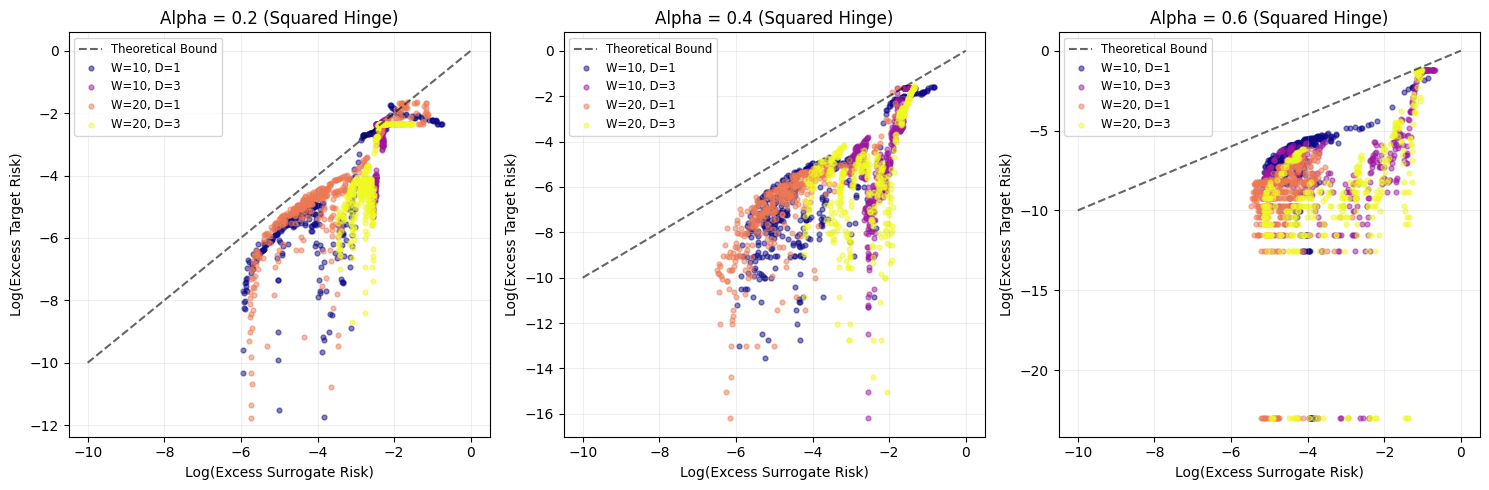

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- 1. Tsybakov Noise and Risk Definitions (Updated for Squared Hinge) ---

eta = lambda x: 1 / (1 + np.exp(-x))
inverse_eta = lambda x: np.log(x / (1 - x))

# Squared Hinge Loss: phi(v) = max(0, 1 - v)^2
def squared_hinge_loss(h_x, y):
    return np.maximum(0, 1 - y * h_x)**2

# Risks for Squared Hinge
# C_surr_star for squared hinge is 4 * eta * (1 - eta)
C_surr_val = lambda h_val, x: eta(x) * squared_hinge_loss(h_val, 1) + (1-eta(x)) * squared_hinge_loss(h_val, -1)
C_surr_star = lambda x: 4 * eta(x) * (1 - eta(x))

C_target_val = lambda h_val, x: eta(x) * (h_val < 0) + (1-eta(x)) * (h_val > 0)
C_target_star = lambda x: np.minimum(eta(x), 1-eta(x))

# --- 2. Dynamic PyTorch Model ---

class DynamicMLP(nn.Module):
    def __init__(self, input_dim, width, depth):
        super(DynamicMLP, self).__init__()
        layers = []
        curr_dim = input_dim
        for _ in range(depth):
            layers.append(nn.Linear(curr_dim, width))
            layers.append(nn.ReLU())
            curr_dim = width
        layers.append(nn.Linear(curr_dim, 1)) # Output Layer (Logits)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_step(model, optimizer, x_chunk, y_chunk):
    optimizer.zero_grad()
    outputs = model(x_chunk).squeeze()
    # Squared Hinge Loss in PyTorch: mean( max(0, 1 - y*h)^2 )
    loss = torch.mean(torch.clamp(1 - y_chunk * outputs, min=0)**2)
    loss.backward()
    optimizer.step()
    return loss.item()

# --- 3. Experiment Function ---

def run_test(X, Y, width, depth, chunk_size=5):
    X_pt = torch.FloatTensor(X)
    Y_pt = torch.FloatTensor(Y)
    
    model = DynamicMLP(input_dim=1, width=width, depth=depth)
    optimizer = optim.SGD(model.parameters(), lr=0.005)
    
    mean_surr_history = []
    mean_target_history = []

    num_chunks = len(X) // chunk_size
    
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        train_step(model, optimizer, X_pt[start_idx:end_idx], Y_pt[start_idx:end_idx])
        
        # Evaluation
        with torch.no_grad():
            h_vals = model(X_pt).numpy().ravel()
            x_flat = X.ravel()
            
            surr_loss = C_surr_val(h_vals, x_flat)
            surr_star = C_surr_star(x_flat)
            target_loss = C_target_val(h_vals, x_flat)
            target_star = C_target_star(x_flat)

            # Excess Risks
            mean_delta_surr = np.mean(surr_loss - surr_star)
            mean_delta_target = np.mean(target_loss - target_star)
            
            mean_surr_history.append(mean_delta_surr)
            mean_target_history.append(mean_delta_target)

    return mean_surr_history, mean_target_history

# --- 4. Main Execution ---

alphas_to_test = [0.2, 0.4, 0.6]
widths_to_test = [10, 20]
depths_to_test = [1, 3]
n_samples = 1000

fig, axes = plt.subplots(1, len(alphas_to_test), figsize=(15, 5))

for ax_idx, alpha in enumerate(alphas_to_test):
    beta = alpha / (1 - alpha)
    # Generate Tsybakov Noise Data
    signal = [((x) ** (1/beta))/2 for x in np.random.rand(n_samples)]
    arr = []
    for t in signal: arr.extend([0.5 + t, 0.5 - t])
    
    X_raw = [inverse_eta(x) for x in arr]
    Y_raw = [np.random.binomial(n=1, p=eta(x))*2 - 1 for x in X_raw]

    indices = np.random.permutation(len(X_raw))
    X = np.array(X_raw)[indices].reshape(-1, 1)
    Y = np.array(Y_raw)[indices]

    ax = axes[ax_idx]
    ax.set_title(f"Alpha = {alpha} (Squared Hinge)")
    
    # Theoretical Bound Line
    x_ref = np.linspace(-10, 0, 100)
    y_ref = (1) * x_ref
    ax.plot(x_ref, y_ref, 'k--', label="Theoretical Bound", alpha=0.6)

    colors = plt.cm.plasma(np.linspace(0, 1, len(widths_to_test)*len(depths_to_test)))
    c_idx = 0

    for width in widths_to_test:
        for depth in depths_to_test:
            s_hist, t_hist = run_test(X, Y, width, depth)
            
            # Log transform (clipping to avoid log(0))
            log_surr = np.log(np.maximum(s_hist, 1e-10))
            log_target = np.log(np.maximum(t_hist, 1e-10))
            
            ax.scatter(log_surr, log_target, s=12, alpha=0.5, 
                       color=colors[c_idx], label=f"W={width}, D={depth}")
            c_idx += 1

    ax.set_xlabel("Log(Excess Surrogate Risk)")
    ax.set_ylabel("Log(Excess Target Risk)")
    ax.legend(fontsize='small')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()